In [ ]:
# Optional: setup NoTexBook theme
%load_ext notexbook

%texify

In [43]:
# UNCOMMENT THIS ONLY if running on Anaconda Notebooks and if needed
# Note: Same modules as in MIA Training notebooks!

# !wget https://raw.githubusercontent.com/leriomaggio/ppml-tutorial/main/3-ml-models-attacks/dataset.py
# !wget https://raw.githubusercontent.com/leriomaggio/ppml-tutorial/main/3-ml-models-attacks/models.py
# !wget https://raw.githubusercontent.com/leriomaggio/ppml-tutorial/main/3-ml-models-attacks/train.py

# Model Inversion Attack - Model Training

In this notebook we will repeat the same operations done in preparation for the **Model Inversion Attack** (in section 1) 

The very **big** difference this time though is that we will be using **Opacus** to train our ML model.

$\rightarrow$ ‼️ The very **remarkable** thing to notice is **how little** the implementation changes wrt. to the previous notebook
(in fact, we will be using the **same** `train` function defined previously)

In [44]:
import torch as th
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline

In [45]:
import warnings
warnings.simplefilter("ignore")

In [46]:
from dataset import ORLFaces
from torchvision.transforms import ToTensor, Grayscale, Compose
from torch.utils.data import DataLoader

In [47]:
SEED = 123456

np.random.seed(SEED)
th.manual_seed(SEED)
if th.cuda.is_available():
    th.coda.manual_seed_all(SEED)
    th.backends.cudnn.deterministic = True

In [48]:
# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib

opener = urllib.request.build_opener()
opener.addheaders = [("User-agent", "Mozilla/5.0")]
urllib.request.install_opener(opener)

from pathlib import Path
import os

DATA_FOLDER = Path(os.path.join(os.path.abspath(os.path.curdir))) / "data"

In [49]:
imgs_trasform = Compose([Grayscale(num_output_channels=1), ToTensor()])

orl_faces_train = ORLFaces(
    root=DATA_FOLDER, download=True, split="train", transform=imgs_trasform
)
orl_faces_test = ORLFaces(
    root=DATA_FOLDER, download=True, split="test", transform=imgs_trasform
)

In [50]:
BATCH_SIZE = 32

train_loader = DataLoader(
    orl_faces_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)
test_loader = DataLoader(
    orl_faces_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False
)

Show some of the training images, for fun

In [51]:
from torchvision.utils import make_grid


def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(10, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [52]:
# get some random training images
images, labels = next(iter(train_loader))

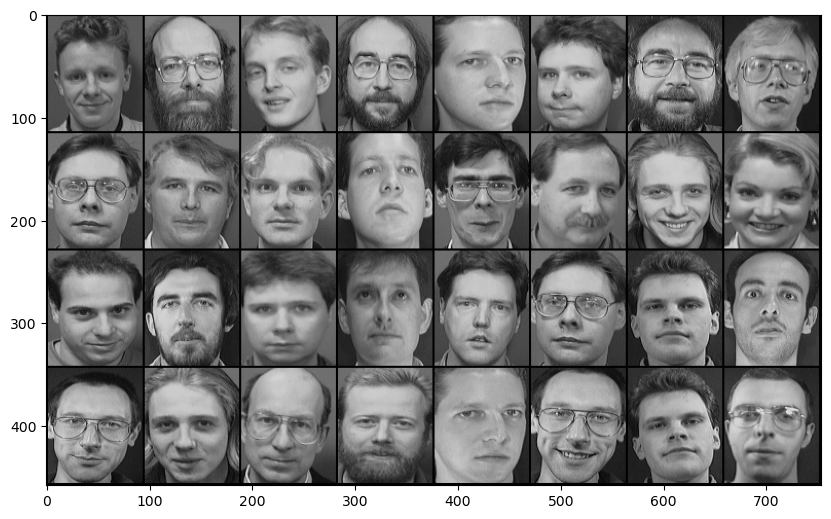

20 36 39 27 0 22 27 1 3 14 17 0 19 24 11 34 8 10 22 23 37 3 35 15 26 11 12 25 0 26 35 18


In [53]:
# show images
imshow(make_grid(images))
# print labels
print(" ".join(f"{labels[j]}" for j in range(BATCH_SIZE)))

## Privacy Parameters and Opacus

In [54]:
from models import SoftmaxRegression, MLP

In [55]:
softmax_reg = SoftmaxRegression()

In [56]:
from opacus.validators import ModuleValidator

errors = ModuleValidator.validate(softmax_reg, strict=False)
errors

[]

In [57]:
λ = 0.1 # optimiser learning rate

In [58]:
softmax_reg = SoftmaxRegression()
softmax_sgd = th.optim.SGD(softmax_reg.parameters(), lr=λ)

In [59]:
from opacus import PrivacyEngine

In [60]:
MAX_GRAD_NORM = 1.2
EPSILON = 0.1
DELTA = 1e-5
EPOCHS = 200  # we have increased by 100 the number of epochs of training

In [61]:
privacy_engine = PrivacyEngine()

softmax_reg, softmax_sgd, train_loader = privacy_engine.make_private_with_epsilon(
    module=softmax_reg,
    optimizer=softmax_sgd,
    data_loader=train_loader,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Using sigma={softmax_sgd.noise_multiplier} and C={MAX_GRAD_NORM}")

Using sigma=160 and C=1.2


In [62]:
from train import train

In [ ]:
train(model=softmax_reg, optimiser=softmax_sgd, loaders=(train_loader, test_loader), 
      model_name="softmax_reg_opacus_test", verbose=False, epochs=600)